In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Download Libraries

In [2]:
%%capture
!pip install transformers

Import Libraries

In [3]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import functional as F
from tqdm.auto import tqdm

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Importing and Processing Data
Data is collected from kaggle - "Sentiment140 dataset with 1.6 million tweets"

In [6]:
names = ["sentiment","id","date","flag","user","text"]
encoding = "ISO-8859-1"
df = pd.read_csv("/gdrive/MyDrive/Sentiment_Classification/training.1600000.processed.noemoticon.csv",encoding = encoding,names = names)
df = df.sample(frac=1).reset_index(drop=True)
df = df[:50000]
df.head()

,sentiment,id,date,flag,user,text
0,4,1686549058,Sun May 03 05:53:31 PDT 2009,NO_QUERY,Andjelija,@jules_88 haha Good luck with that
1,0,2285968456,Mon Jun 22 15:49:22 PDT 2009,NO_QUERY,brandyellen,@MommaDJane She just got 3rd place like twice!...
2,4,1994340211,Mon Jun 01 11:47:05 PDT 2009,NO_QUERY,QTPiK8,@Aarathon Yes! Do it! I'm in the lottery.
3,4,1686138423,Sun May 03 03:57:55 PDT 2009,NO_QUERY,xTreenax,"@skyblues4eva I'm o.k, thanks. Better than I w..."
4,0,1694507157,Mon May 04 02:56:36 PDT 2009,NO_QUERY,bettyroseutz,feeling like crap! Why is it that when you hav...


In [7]:
df = df.drop(["id","date","flag","user"],axis=1)

In [8]:
df.sentiment.unique()

array([4, 0])

In [9]:
df['sentiment'] = df.sentiment.replace(4,1)
df.head()

,sentiment,text
0,1,@jules_88 haha Good luck with that
1,0,@MommaDJane She just got 3rd place like twice!...
2,1,@Aarathon Yes! Do it! I'm in the lottery.
3,1,"@skyblues4eva I'm o.k, thanks. Better than I w..."
4,0,feeling like crap! Why is it that when you hav...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'positive')]

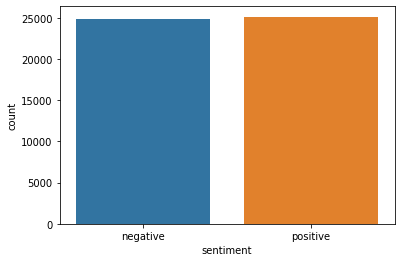

In [10]:
class_names = ['negative', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('sentiment')
ax.set_xticklabels(class_names)

 Load a pre-trained BertTokenizer:

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
sample_txt = df["text"][0]

In [14]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: @jules_88 haha Good luck with that 
   Tokens: ['@', 'j', '##ules', '_', '88', 'ha', '##ha', 'Good', 'luck', 'with', 'that']
Token IDs: [137, 179, 11806, 168, 5385, 5871, 2328, 2750, 6920, 1114, 1115]


Special Tokens

In [15]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [16]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [17]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [18]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [19]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=128,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [20]:
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

tensor([  101,   137,   179, 11806,   168,  5385,  5871,  2328,  2750,  6920,
         1114,  1115,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

Creating Custom DataLoader

In [21]:
class SentimentDataset(Dataset):
  def __init__(self, data, targets, tokenizer = tokenizer, max_len = 128):
    self.text = data
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Spliting Dataset into Train, Valid, Test sets

In [22]:
df_train, df_test = train_test_split( df, test_size=0.25, random_state=0, shuffle=True, stratify = df['sentiment'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=0, shuffle=True, stratify = df_test['sentiment'])

In [23]:
len(df_train),len(df_test),len(df_val)

(37500, 6250, 6250)

In [24]:
def create_data_loader(df, batch_size = 16, max_len = 128,tokenizer = tokenizer):
  dataloader = SentimentDataset(
    data=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    dataloader,
    batch_size=batch_size
  )

Creating Model

In [25]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes = 2):
    super(SentimentClassifier, self).__init__()

    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.dropout = nn.Dropout(0.25)
    self.output = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, X = self.bert(input_ids=input_ids,attention_mask=attention_mask)
    X = self.dropout(X)
    return self.output(X)

In [42]:
class Trainer:
    def __init__(self, model, optimizer, load_pretrained=True, loss_function = None, device = device):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 2, gamma=0.9, verbose=True)
        self.device = device
        if not loss_function:
          self.loss_fn = nn.CrossEntropyLoss().to(self.device)
        else:
          self.loss_fn = loss_function
        self.best_loss = None
        if load_pretrained:
            self.load() 

    def fit(self, train_loader, val_data_loader, epoch_num, train_length, val_length, save = True):
        train_loader = tqdm(train_loader)
        train_loader = enumerate(train_loader)
        self.model.train()
        losses = []
        correct_predictions = 0
        for i,d in train_loader:
            input_ids = d["input_ids"].to(self.device)
            attention_mask = d["attention_mask"].to(self.device)
            targets = d["targets"].to(self.device)
            self.optimizer.zero_grad()
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)
            loss = self.loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
        val_acc, val_loss = self.validate(val_data_loader,val_length)
        self.scheduler.step()
        print("Epoch-[{}], Train loss: {:.4f}, Train Acc: {:.4f} || Valid loss: {:.4f}, Valid Acc: {:.4f} ".format(epoch_num, np.mean(losses), correct_predictions.double() / train_length, val_loss, val_acc))
        if save:
          if self.best_loss == None:
            self.best_loss = val_loss
            self.save()
          if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save()

    def validate(self, val_data_loader,val_length):
        valid_loader = tqdm(val_data_loader)
        valid_loader = enumerate(valid_loader)
        self.model.eval()
        losses = []
        correct_predictions = 0
        with torch.no_grad():
            for i,d in valid_loader:
                input_ids = d["input_ids"].to(self.device)
                attention_mask = d["attention_mask"].to(self.device)
                targets = d["targets"].to(self.device)
                outputs = model(input_ids=input_ids,attention_mask=attention_mask)
                outputs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, dim=1)
                loss = self.loss_fn(outputs, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        return correct_predictions.double() / val_length, np.mean(losses)

    def save(self):
        torch.save(self.model.state_dict(), "/gdrive/MyDrive/Sentiment_Classification/sentiment_model.pth")
        print("model saved!!")
    
    def load(self):
        print("loading weights...")
        self.model.load_state_dict(torch.load( "/gdrive/MyDrive/Sentiment_Classification/sentiment_model.pth"))
        print("weights loaded..")

    def test(self, test_dataloader, load):
        test_loader = tqdm(test_dataloader)
        test_loader = enumerate(test_loader)
        if load:
          self.load() 
        self.model.eval()
        texts_ = []
        predictions = []
        prediction_probs = []
        real_values = []
        with torch.no_grad():
          for i,d in test_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            outputs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)
            texts_.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return texts_, predictions, prediction_probs, real_values

In [43]:
model = SentimentClassifier()
model = model.to(device)
optimizer = Adam(model.parameters(), lr = 0.0001,betas=(0.5, 0.999))
trainer = Trainer(model, optimizer, load_pretrained=False)
BATCH_SIZE = 80
train_data_loader = create_data_loader(df_train, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adjusting learning rate of group 0 to 1.0000e-04.


In [44]:
for epoch in range(5):
    trainer.fit(train_data_loader, val_data_loader, epoch, len(df_train), len(df_val), save = True)

Model is trained with a subset of data for 2-3 epochs and pretained weights are used while inferencing

In [52]:
y_review_texts, y_pred, y_pred_probs, y_test = trainer.test(test_data_loader,load = True)

  0%|          | 0/79 [00:00<?, ?it/s]

loading weights...
weights loaded..


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3105
           1       0.77      0.85      0.81      3145

    accuracy                           0.80      6250
   macro avg       0.80      0.80      0.79      6250
weighted avg       0.80      0.80      0.79      6250



Text(0.5, 15.0, 'Predicted sentiment')

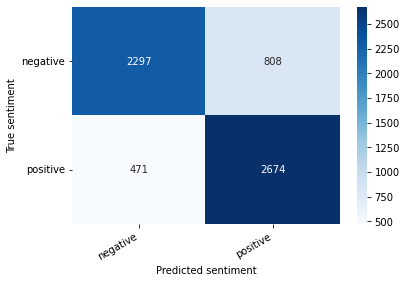

In [54]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment')

In [55]:
predictions = pd.DataFrame({"Text":y_review_texts,"Prediction":y_pred,"Ground Truth":y_test,"Prediction Probabilities":y_pred_probs})

In [58]:
predictions.iloc[7]

Text                        Is a cracking sunny morning in belfast it 
Prediction                                                           1
Ground Truth                                                         1
Prediction Probabilities              (tensor(0.0315), tensor(0.9685))
Name: 7, dtype: object

In [59]:
predictions.iloc[8]

Text                        I hate when people tell me dreams can't come t...
Prediction                                                                  0
Ground Truth                                                                0
Prediction Probabilities                     (tensor(0.9998), tensor(0.0002))
Name: 8, dtype: object